# Сегментация пользователей по потреблению в банке

Изучены пользователи банка «Метанпром» и проведена их сегментация по количеству потребляемых продуктов, обращая особое внимание на отток. Проведен статистический анализ данных и проверены статистические гипотезы. Построены гистограммы и тепловые карты. Визуализирован дашборд и подготовлена презентация.

Исследование проведено в четыре этапа:
 1. Обзор и предобработка данных.
 2. Исследовательский анализ данных.
 3. Формулировка и проверка статистических гипотез.
 4. Сегментация пользоватей на основании полученных результатов.

### Стэк:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import math as mth
from scipy import stats as st
from scipy.stats import spearmanr

## Обзор и предобработка данных.

Используем функцию для ознакомления с данными:

In [2]:
def fst_imp(data):
    """This function is giving first impression of data."""
    return (display(data.head(3)),
            print(data.info()), 
            print('---------------------------------------------'),
           
            pd.set_option('display.float_format', lambda x: '%.3f' % x), #Suppress Scientific Notation to correct ".display()" output
            display(data.describe()),
            print("Exact duplicates:", data.duplicated().sum()),
            print(" "),
            print("Blanks by columns:"),
            display(pd.DataFrame(round(data.isna().mean()*100,2)).style.background_gradient('coolwarm')))

Составим первое представление о данных и возможных ошибках в данных.

In [3]:
df = pd.read_csv('bank_scrooge.csv') # прочитаем csv файл с разделителями "\t"
print(fst_imp(df))

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB
None
---------------------------------------------


,USERID,score,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
count,10000.000,10000.000,9974.000,10000.000,7705.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,171814.713,848.699,42.734,2.628,827794.307,1.870,0.680,0.523,147866.886,0.182
std,33708.238,65.449,12.180,1.981,1980614.147,0.793,0.466,0.499,139388.511,0.386
min,94561.000,642.000,18.000,0.000,0.000,0.000,0.000,0.000,2546.300,0.000
25%,142810.250,802.000,33.000,0.000,295554.160,1.000,0.000,0.000,75251.900,0.000
50%,172728.000,853.000,40.000,3.000,524272.200,2.000,1.000,1.000,119658.105,0.000
75%,201261.750,900.000,51.000,4.000,980705.850,2.000,1.000,1.000,174500.542,0.000
max,229145.000,1000.000,86.000,9.000,119113552.010,5.000,1.000,1.000,1395064.450,1.000


Exact duplicates: 0
 
Blanks by columns:


,0
USERID,0.000000
score,0.000000
city,0.000000
gender,0.000000
age,0.260000
equity,0.000000
balance,22.950000
products,0.000000
credit_card,0.000000
last_activity,0.000000


(None, None, None, None, None, None, None, None, None)


Явных дубликатов в датасете нет. Проверим, есть ли неявные дубликаты. Для этого посмотрим на уникальные значения в столбцах с типом данные `object`

In [4]:
df = df.rename(columns = {
    'USERID':'user_id','EST_SALARY': 'est_salary'
    })# Приведем все названия колонок к общему виду.

print('Уникальные значения в столбце "city":', df['city'].unique())
print('Уникальные значения в столбце "gender":', df['gender'].unique())

Уникальные значения в столбце "city": ['Рыбинск' 'Ярославль' 'Ростов']
Уникальные значения в столбце "gender": ['Ж' 'М']


Таким образом, мы выявили, что в датасете нет неявных дубликатов.

Также мы заметили пропуски в датасете в столбцах "age" и "balance". Пропуски в возрасте занимают менее 1% данных, поэтому их можно удалить.

In [5]:
df = df.dropna(subset=['age']) #удалим 0,26% данных с пропусками в столбце "age"

Далее, взглянем на пропуски в столбце 'balance'

In [6]:
filtered_df = df[df['balance'].isnull()]
filtered_df.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
2,120722,892.000,Рыбинск,Ж,30.000,0,NaN,1,1,1,107683.340,0
9,133130,906.000,Ярославль,Ж,67.000,0,NaN,1,0,1,238055.530,0
10,148929,927.000,Ростов,М,52.000,0,NaN,1,1,1,196820.070,0
11,172184,921.000,Ростов,М,41.000,0,NaN,1,1,1,217469.480,0
19,127034,922.000,Рыбинск,Ж,53.000,0,NaN,1,0,0,147094.820,0


На первый взгляд, данные также кажутся разнородными. Исследуем данные с помощью `.describe()`.

In [7]:
filtered_df.describe()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,2279.000,2279.000,2279.000,2279.000,0.000,2279.000,2279.000,2279.000,2279.000,2279.000
mean,171904.886,865.357,42.093,0.051,NaN,1.163,0.815,0.549,226345.417,0.006
std,33303.215,89.554,11.942,0.227,NaN,0.404,0.388,0.498,199825.591,0.075
min,114182.000,642.000,18.000,0.000,NaN,0.000,0.000,0.000,20274.030,0.000
25%,142992.500,871.000,33.000,0.000,NaN,1.000,1.000,0.000,120217.385,0.000
50%,172304.000,903.000,40.000,0.000,NaN,1.000,1.000,1.000,174347.870,0.000
75%,201257.000,922.000,49.000,0.000,NaN,1.000,1.000,1.000,240372.775,0.000
max,229145.000,990.000,86.000,3.000,NaN,3.000,1.000,1.000,1333687.360,1.000


Итак, судя по полученной таблице можно сказать, что средний возраст в отфильтрованном датасете соответсвует среднему возрасту всего датасета, однако количество объектов для 75% клиентов - 0. При этом медиана зарплат явно выше чем в общем датасете (174 тыс против 119 тыс. руб.). Более того, более 75% клиентов являются активными пользователями банка. Поэтому, удалять данные 2295 пропусков нецелесообразно. Поэтому следует оставить данные пропуски.

Таким образом, мы практически можем приступать к анализу. Однако, для того чтобы провести корелляционный анализ, нам нужно чтобы все переменные для анализа имели числовые характеристики. Для этого, произведем кодировку двух категориальных признаков 'gender' и 'city'.

In [8]:
df_copy = df.copy() 
df = pd.get_dummies(df, columns=['gender', 'city']) 
df['city'] = df_copy['city'] 
df['gender'] = df_copy['gender'] 
df.head()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_Ж,gender_М,city_Ростов,city_Рыбинск,city_Ярославль,city,gender
0,183012,850.000,25.000,1,59214.820,2,0,1,75719.140,1,1,0,0,1,0,Рыбинск,Ж
1,146556,861.000,37.000,5,850594.330,3,1,0,86621.770,0,1,0,0,1,0,Рыбинск,Ж
2,120722,892.000,30.000,0,NaN,1,1,1,107683.340,0,1,0,0,1,0,Рыбинск,Ж
3,225363,866.000,51.000,5,1524746.260,2,0,1,174423.530,1,1,0,0,0,1,Ярославль,Ж
4,157978,730.000,34.000,5,174.000,1,1,0,67353.160,1,0,1,0,0,1,Ярославль,М


Теперь данные готовы для анализа.

## Исследовательский анализ данных.

Проведем корреляционный анализ оттока клиентов, для того чтобы определить наиболее влиятельные параметры.
Составим матрицу корреляции по столбцу 'churn' и визуализируем ее с помощью метода `.style.background_gradient()`

In [9]:
(pd.DataFrame((round(df.corrwith(df['churn'], method='spearman')*100,2))
             .sort_values(ascending=False).drop(labels=['churn']))
             .style.background_gradient('coolwarm_r'))


,0
products,27.080000
equity,26.760000
balance,20.250000
last_activity,16.940000
gender_М,14.160000
score,9.700000
est_salary,3.730000
city_Ярославль,2.400000
city_Ростов,0.500000
user_id,-0.770000


Судя по полученной матрице, явно влиятельных параметров на отток клиентов нет, но среди всех параметров мы можем выделить наличие продуктов, объектов в собственности, баланс и клиентскую активность по положительному влиянию на отток, а также пол, наличие кредитной карты и возраст по отрицательному влиянию на отток. Далее нам необходимо исследовать оток в разрезе этих признаков, но для этого надо изучить признаки на предмет наличия аномалий.

Для начала разделим признаки на две категории: дискретные и бинарные.

In [10]:
#параметры с количественным типом данных 
numeric_parameters = {    
    'age': 'Возраст',
    'balance': 'Баланс на счету'  
}

discrete_parameters = {    
    'equity': 'Количество объектов в собственности', 
    'products': 'Количество продуктов'    
}

#параметры с бинарным типом данных 
binar_parameters = {    
    'credit_card': 'Наличие кредитной карты',
    'last_activity': 'Активность клиента', 
    'gender_Ж': 'Женщины',
    'gender_М': 'Мужчины'
}

Далее, при помощи цикла построим боксплоты и вычислим медиану для признаков с непрерывными величинами.

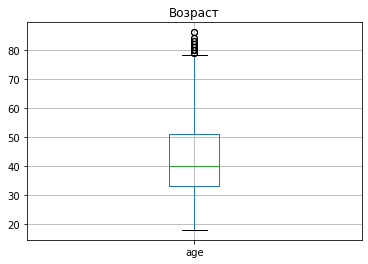

Медиана в столбце " Возраст " равна 40.0


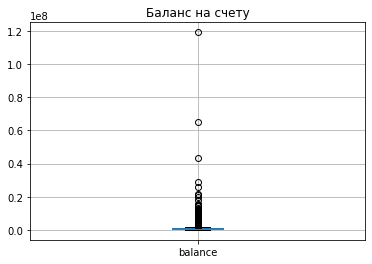

Медиана в столбце " Баланс на счету " равна 524295.33


In [11]:
for title in numeric_parameters:
    df.boxplot(title)
    plt.title(numeric_parameters.get(title))
    plt.show()
    print('Медиана в столбце "', numeric_parameters.get(title),'" равна', df[title].median())


Мы обнаружили наличие значительного количества аномалий в признаке "Balance" и "Age". Выделим эти аномалии в отдельные столбцы. Для этого создадим функцию на обнаружение аномалий. 

In [12]:
def anomaly_column(item,title):
    """
    Возвращает бинарное значение по значению параметра используя правила
    - '1', если значение параметра выходит за пределы  верхней границы нормальных значений;
    - '0', если значение находится ниже верхней границы нормальных значений.
    """
    
     # расчет IQR для параметра 
    q1 = df[title].quantile(0.25)#создание 1го квартиля
    q3 = df[title].quantile(0.75)#создание 3го квартиля
    iqr = q3 - q1
     # верхняя граница значений
    x_min = q1 - 1.5 * iqr
    x_max = q3 + 1.5 * iqr
    
    if  x_min < item < x_max: return 0
    return 1

Итак, теперь применим данную функцию к нашим признакам и с помощбю `pd.to_numeric()` преобразуем полученные данные в числовую форму.

In [13]:
df['balance_is_anomaly'] = pd.to_numeric(df['balance'].apply(anomaly_column, title='balance'))
df['age_is_anomaly'] = pd.to_numeric(df['age'].apply(anomaly_column, title='age'))

Далее создадим общий столбец, указывающий на наличие любой аномалии в датасете.

In [14]:
df['is_any_anomaly'] = df['balance_is_anomaly']+ df['age_is_anomaly'] #здесь получим сумму столбцов с результатами 0,1 или 2

#создадим функцию, преобразующую любую цифру отличную от нуля в 1
def is_anomaly_correction(item):
    """
    Возвращает бинарное значение в столбце "is_any_anomaly" используя правила
    - '1', если значение параметра >1;
    - '0', если значение <1.
    """
   
    if  item > 0: return 1
    return 0

df['is_any_anomaly'] = df['is_any_anomaly'].apply(is_anomaly_correction)

df.head()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_Ж,gender_М,city_Ростов,city_Рыбинск,city_Ярославль,city,gender,balance_is_anomaly,age_is_anomaly,is_any_anomaly
0,183012,850.000,25.000,1,59214.820,2,0,1,75719.140,1,1,0,0,1,0,Рыбинск,Ж,0,0,0
1,146556,861.000,37.000,5,850594.330,3,1,0,86621.770,0,1,0,0,1,0,Рыбинск,Ж,0,0,0
2,120722,892.000,30.000,0,NaN,1,1,1,107683.340,0,1,0,0,1,0,Рыбинск,Ж,1,0,1
3,225363,866.000,51.000,5,1524746.260,2,0,1,174423.530,1,1,0,0,0,1,Ярославль,Ж,0,0,0
4,157978,730.000,34.000,5,174.000,1,1,0,67353.160,1,0,1,0,0,1,Ярославль,М,0,0,0


Далее, изучим выделенные нами параметры без аномалий при помощи гистограмм. 

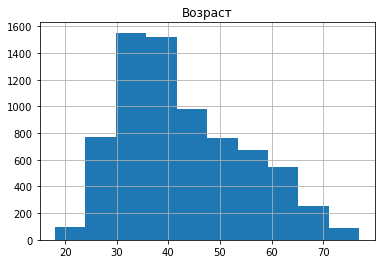

Среднее значение в параметре Возраст равно 40.0
Верхняя граница нормальных значений 77.0


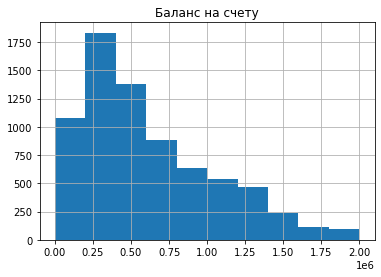

Среднее значение в параметре Баланс на счету равно 488317.905
Верхняя граница нормальных значений 1999799.18


In [16]:
parameters = numeric_parameters

for title in parameters:
        df_wht_anml = df.query('is_any_anomaly<1')
        
        ax = df_wht_anml[title].hist()#строим гистограмму
        ax.set_title(parameters.get(title))#устанавливаем название графика
        
        plt.show()
    
        print('Среднее значение в параметре', parameters.get(title), 'равно', df_wht_anml[title].median())
        print('Верхняя граница нормальных значений',  df_wht_anml[title].max())
   

По полученным гистограммам можно сделать вывод, что средний пользователь банка возраста 40 лет имеет около 0,5 млн. руб. на счете. 

Далее изучим дескретные признаки.

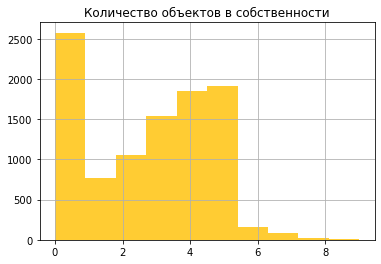

Среднее значение в параметре Количество объектов в собственности равно 3.0


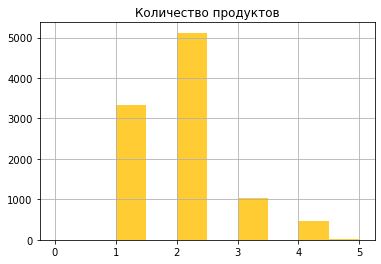

Среднее значение в параметре Количество продуктов равно 2.0


In [17]:
parameters = discrete_parameters

for title in parameters:
        myhex = '#FFCC33' #парметр задающий цвет #парметр задающий цвет
        ax = df[title].hist(color=myhex)#строим гистограмму
        ax.set_title(parameters.get(title))#устанавливаем название графика
        plt.show()
    
        print('Среднее значение в параметре', parameters.get(title), 'равно', df[title].median())    

По полученным гистограммам можно сделать вывод, что средний пользователь банка находится в возрасте 40 лет, имеет 3 объекта в собственности и около 0,5 млн.руб. на балансе, а также пользуется 2мя банковскими продуктами. \
Исследуем признак "Age" в разрезе клиентского оттока при помощи графика типа `kdeplot`.

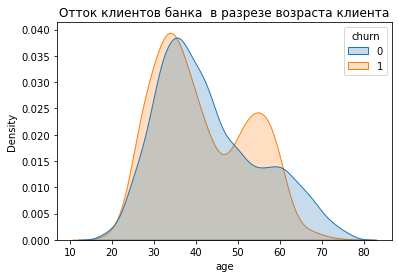

In [18]:
df_wht_anomaly = df.query('age_is_anomaly<1')#создадим датафрейм без аномалий по возрасту 
sns.kdeplot(data=df_wht_anomaly, x='age', hue='churn', fill=True, common_norm=False)
plt.title('Отток клиентов банка  в разрезе возраста клиента')

plt.show()

Судя по полученному, от банка склонны уходить люди в возрасте 25-35 и 50-60 лет. Таким образом, предварительными группами для сегментации по возрасту могут быть группы 25-35 лет и 50-60 лет. \
Далее, исследуем признак "Balance" в разрезе оттока, построив гистограмму.

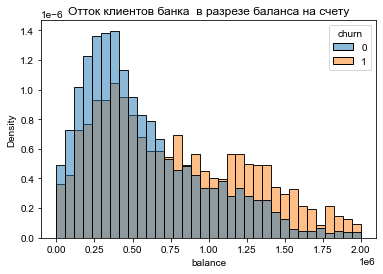

In [19]:
df_wht_anomaly = df.query('balance_is_anomaly<1')#создадим датафрейм без аномалий по балансу 
rc=sns.histplot(data=df_wht_anomaly, x='balance', hue='churn', stat='density', common_norm=False)
sns.set(rc={'figure.figsize':(15,5)})
plt.title('Отток клиентов банка  в разрезе баланса на счету')
plt.show()   

Что касается баланса, то здесь начинается отток клиентов после наличия на балансе в 750 тыс.

Посмотрим на отток в признаках "equity" и "products" при помощи тепловых карт.

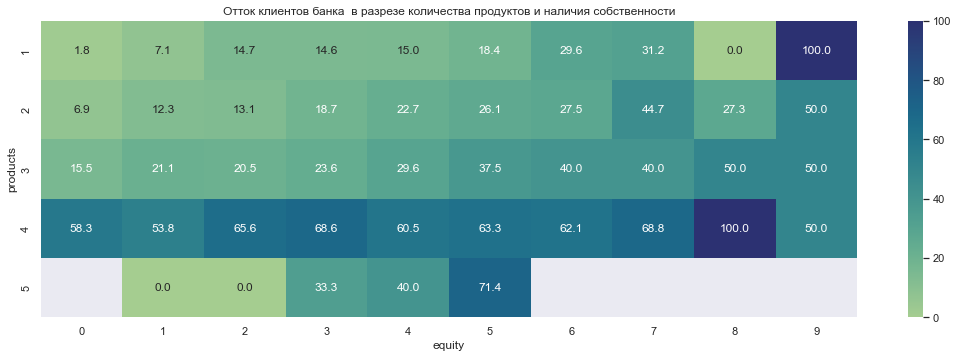

In [20]:
products_filtered = df.query('products>0') #очистим фрейм от клиентов не имеющих продуктов

pivoted = pd.pivot_table(products_filtered, values='churn', index='products', columns='equity', aggfunc='mean')*100 
ax = sns.heatmap(data=pivoted, annot=True, fmt='.1f',cmap="crest")
plt.tight_layout()
plt.title('Отток клиентов банка  в разрезе количества продуктов и наличия собственности')
plt.show()

По тепловой карте мы можем определить, что люди с наибольшим количеством собственности имееют большую склонность к уходу из банка. Тоже самое можно сказать и о продуктах банка. Люди с 4-5 продуктами уходят с большей вероятностью из банка. Предварительно, мы можем разделить пользователей на группы по собственности: 0-4 и 5-9. Что касается количества продуктов, то график можно разбить на две группы по продуктам: 4-5 продуктов и 1-3 продукта.

Далее, ислледуем параметры с бинарным типом данных: пол, активность клиента и наличие кредитной карты. Для начала определим общий процент оттока.


In [21]:
churn_rate = df['churn'].mean()*100
print('Общий уровень оттока в процентах:',churn_rate)

Общий уровень оттока в процентах: 18.237417284940847


Теперь определим долю клиентов и уровень оттока в каждом признаке.

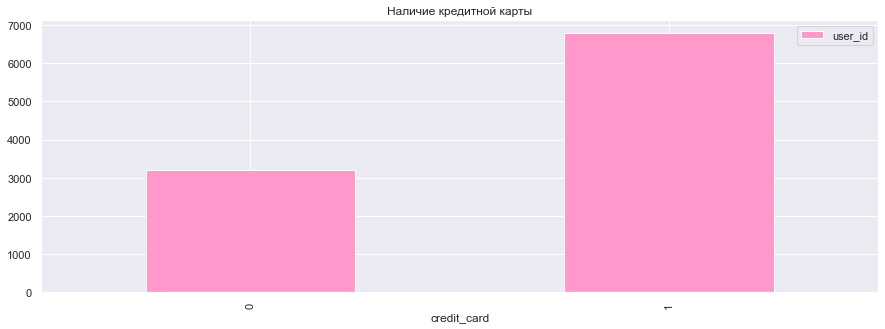

Доля клиентов в параметре Наличие кредитной карты 68.02


,"Доля оттока в параметре ""Наличие кредитной карты"""
credit_card,
0,0.256
1,0.148


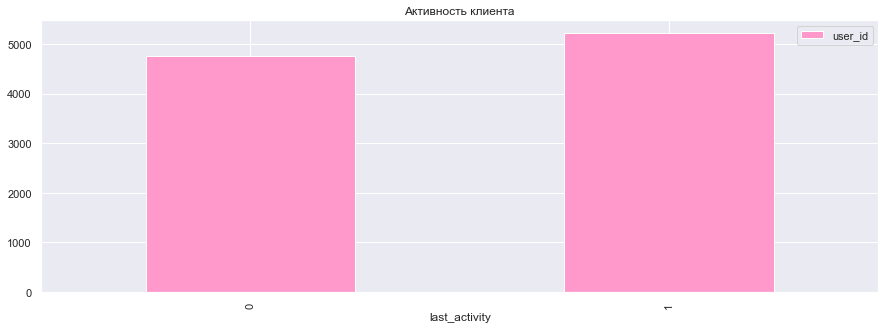

Доля клиентов в параметре Активность клиента 52.29


,"Доля оттока в параметре ""Активность клиента"""
last_activity,
0,0.114
1,0.245


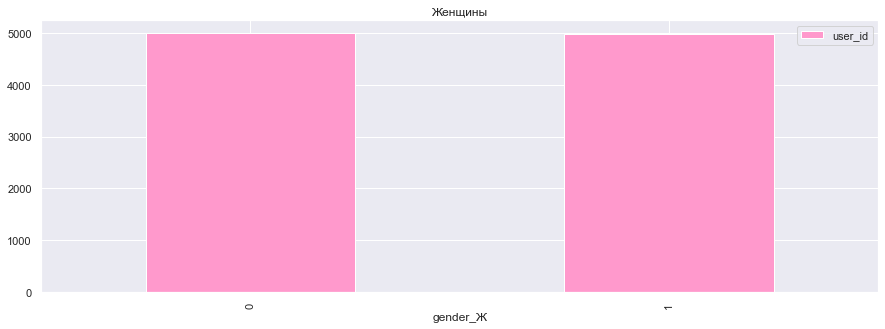

Доля клиентов в параметре Женщины 49.96


,"Доля оттока в параметре ""Женщины"""
gender_Ж,
0,0.237
1,0.128


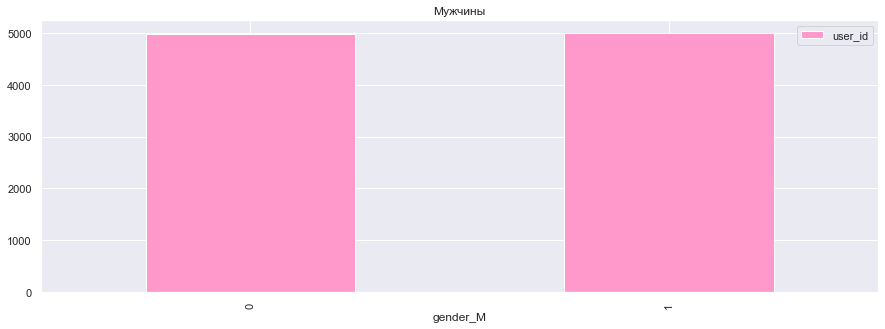

Доля клиентов в параметре Мужчины 50.04


,"Доля оттока в параметре ""Мужчины"""
gender_М,
0,0.128
1,0.237


In [22]:
binar_parameters = {    
    'credit_card': 'Наличие кредитной карты',
    'last_activity': 'Активность клиента', 
    'gender_Ж': 'Женщины',
    'gender_М': 'Мужчины'
}
for title in binar_parameters:

    myhex = '#FF99CC' #параметр задающий  цвет
    print()
    ax = (df.groupby(title)
     .agg({'user_id':'count'})
     .plot(kind='bar',
           color = myhex)
    );

    ax.set_title(binar_parameters.get(title))
    plt.show()
    title_rate = round(df[title].mean()*100,2)
    churn_rate_by_title = df.pivot_table(index = df[title], 
                                           values = 'churn', 
                                           aggfunc = 'mean')
    churn_rate_by_title.columns = ['churn_rate']

    churn_rate_by_title.columns = [f'Доля оттока в параметре "{binar_parameters.get(title)}"']
    
    print('Доля клиентов в параметре', binar_parameters.get(title), title_rate)
    display(churn_rate_by_title)


Судя по полученным таблицам мы видим, что среди клиентов, имеющих кредитную карту, 15% ушли из банка, в то время как 26% ушедших не имеют кредитной карты. Среди активных клиентов процент оттока составляет 24%, а неактивные клиенты уходят реже - 11%. Среди женщин процент ушедших составляет 13%, в то время как среди мужчин этот показатель выше: 24%.

Таким образом, мы можем сделать вывод, что средний пользователь мужского пола без кредитной карты и высокой активностью чаще склонен к уходу из банка. 

### Вывод

Мы определили позитивно и негативно влияющие параметры на отток клиента и исследовали каждый из них отдельно в разрезе оттока. Для сегментации по оттоку мы предварительно определили различия по возрасту и количеству собственности. Далее, при помощи проверки статистических гипотез определим различия между группами в разрезе 1-2 продуктов и проверим насколько статистически значима разница между мужчинам и и женщинами.

## Формулировка и проверка статистических гипотез.

Мы провели исследование и анализ данных и определили, что наиболее явную взаимосвязь с оттоком имеют такие признаки, как возраст, баланс на счете, количество продуктов и объектов в собственности, наличие кредитной карты, активность пользования и, что интересно, пол. \
Для того, чтобы убедиться в том, что признаки определены правильно, проведем статистический тест на выявление статистической разности между группами в признаке "количество продуктов" и "пол". 

Проверим гипотезу различия возраста между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним. Для этого сформулируем нулевую и альтернативную гипотезы. Установим нулевую гипотезу о равенстве статистических критериев и противопоставим ей альтернативную гипотезу:

H₀: Статистические критерии не находят разницу в возрасте между группами 1го и 2х продуктов;\
H₁: Статистические критерии находят разницу в возрасте между группами 1го и 2х продуктов.

Сформируем группы для теста.

In [23]:
one_product_users = df['age'][df['products']==1]
two_product_users = df['age'][df['products']==2]

print('Количество пользователей одного продукта',one_product_users.shape[0])
print('Количество пользователей двух продуктов',two_product_users.shape[0])

Количество пользователей одного продукта 3323
Количество пользователей двух продуктов 5119


Поскольку мы будем проверять дискретный признак (продукт) и количественный(возраст) и в предыдущем пункте мы заметили, что распределение количественного признака отличное от нормального, то для проверки гипотез мы будем использовать u-критерий.

In [24]:
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(one_product_users, two_product_users)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.'
    ) 

p-значение:  0.057138410813417605
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.


Таким образом, нам не удалось отвергнуть нулевую гипотезу, а значит разница в среднем возрасте между клиентами с одним продуктом и клиентами с двумя продуктами не имеет статистической значимости. 

Далее, сделаем еще одну статистическую проверку на наличие значимой разницы между мужчинами и женщинами в разрезе оттока. Для начала, сформируем две группы оттока по полу. 

In [25]:
women_churn = df['churn'][df['gender_Ж']==1]
men_churn = df['churn'][df['gender_М']==1]

print('Количество женщин в выборке',women_churn.shape[0])
print('Количество мужчин в выборке',men_churn.shape[0])

Количество женщин в выборке 4983
Количество мужчин в выборке 4991


Далее сформулируем  нулевую и альтернативную гипотезы. Установим нулевую гипотезу о равенстве статистических критериев и противопоставим ей альтернативную гипотезу:

H₀: Статистические критерии не находят разницу в оттоке между группами мужчин и женщин;\
H₁: Статистические критерии находят разницу в оттоке  между группами мужчин и женщин.

Поскольку мы будем проверять бинарную переменную, т.е. будем проверять разницу долей оттока между мужчинами и женщинами, мы будем использовать z-value.

Сначала сформируем количество пропорции оттока по группам.

In [26]:
women_churn_count = women_churn[women_churn==1].count() #количество женщин ушедших из банка
women_count= women_churn.count() #общее количество женщин

men_churn_count = men_churn[men_churn==1].count() #количество мужчин ушедших из банка
men_count= men_churn.count() #общее количество мужчин


Далее, зададим критический уровень статистической значимости и составим пропорции ушедших пользователей в обеих группах, а также пропорцию оттока в комбинированном датасете.

In [27]:
alpha = .05 # критический уровень статистической значимости

# пропорция оттока среди  женщин:
p1 =  women_churn_count/ women_count

# пропорция оттока среди мужчин:
p2 = men_churn_count/ men_count

# пропорция оплаты в комбинированном датасете:
p_combined = (women_churn_count +men_churn_count)/(women_count + men_count)

#разница пропорций в датасетах
difference = p1 - p2

Считаем статистику в стандартных отклонениях стандартного нормального распределения: 

In [28]:
#считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/women_count + 1/men_count))

#задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между группами есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группами разными")

p-значение:  0.0
Отвергаем нулевую гипотезу: между группами есть значимая разница


P-value оказался меньше чем критический уровень статистическй значимости, а значит между группами разница имеет статистическую значимость. Таким образом, мы выяснили что гендерный признак нельзя исключать из сегментации и теперь мы можем сформулировать окончательные признаки для сегментации.

### Вывод

Мы сформулировали гипотезу о различии возраста между клиентами одного и двух продуктов и выявили, что разница не имеет статистической значимости, а значит, этих пользователей можно объединить в одну группу. Также мы проверили гипотезу различия между мужчинами и женщинами по оттоку и определили, что разница определенно есть, что значит мы будем учитывать гендерный признак при дальнейшей сегментации клиентов.


## Сегментация пользоватей по уровню потребления на основании полученных результатов.

Ранее, мы определили что общий отток клиентов из банка составляет 18,2%. Будем считать эту цифру нормой оттока. Это значит, что мы должны определить сегменты клиентов по количеству потребляемых продуктов с оттоком, который будет больше общего уровня оттока не менее чем на 5%.
Предварительно установлено что основной признак, по которому мы будем делать сегментацию - Количество потребляемых продуктов: 1-3 и 4-5 продуктов. 

Итак, мы определили следующие параметры, по которым мы будем сегментировать отточных пользователей:

1. Возраст: 25-35 лет и 50-60 лет.
2. Пол: мужчины и женщины.
3. Уровень баланса: более 750 тыс. руб.
4. Количество объектов в собственности: 0-4 и 5-9.


Создадим функцию, которая разделит наш датасет на категории продуктов.

In [29]:
def product_qty(item):
    """
    Возвращает категорию по количеству продуктов products используя правила
    - '1-3', если products <= 3;
    - '4-5 продуктов', если products >3.
    """
    if item <= 3: return ' 1-3 продукта '
    
    return ' 4-5 продуктов '

df['product_qty'] = df['products'].apply(product_qty)
print(df['product_qty'].drop_duplicates())   
    

0       1-3 продукта 
76     4-5 продуктов 
Name: product_qty, dtype: object


Далее, создадим функцию для выделения групп пользователей с интересующими нас возрастными диапазонами.

In [30]:
def age_category(item):
    """
    Возвращает категорию возраста age используя правила
    - '25-35 лет', если age больше 25, но меньше 35;
    - '50-60 лет', если age больше 50, но меньше 60;
    - 'non valid', если age не попадает ни в один из указанных диапазонов выше.
    """
    if 25<=item <= 35: return ' 25-35 лет'
    if 50<=item <= 60: return ' 50-60 лет'
    return ' other age'

df['age_category'] = df['age'].apply(age_category)
print(df['age_category'].drop_duplicates())   
  

0     25-35 лет
1     other age
3     50-60 лет
Name: age_category, dtype: object


Далее, создадим функцию, которую разделит наш датасет на категории количества собственности.

In [31]:
def equity_category(item):
    """
    Возвращает категорию собственности equity используя правила
    - '0-4 объекта', если equity меньше 5;
    - '5-9 объектов', если equity более 5.
    """
    if item <= 4: return '0-4 объекта'
    return '5-9 объектов'

df['equity_category'] = df['equity'].apply(equity_category)
print(df['equity_category'].drop_duplicates()) 

0     0-4 объекта
1    5-9 объектов
Name: equity_category, dtype: object


In [32]:
def balance_category(item):
    """
    возращает категорию баланса более или менее 750 тыс. руб.
    """
    if item >= 750000: return 'более 0,75 млн.руб.'    
    return 'менее 0,75 млн.руб.'

df['balance_category'] = df['balance'].apply(balance_category)
print(df['balance_category'].drop_duplicates())   
  

0    менее 0,75 млн.руб.
1    более 0,75 млн.руб.
Name: balance_category, dtype: object


Проверим себя: отфильтруем датасет по установленным параметрам, наиболее влияющих на отток.

In [33]:
df_filtered = df.query(" age_category != ' other age'")
print('После фильтрации возраста осталось пользователей:', df_filtered.shape[0])
df_filtered = df_filtered.query('balance>=750000')
print('После фильтрации баланса осталось пользователей:', df_filtered.shape[0])
print('Доля оттока в отфильтрованном датасете', round(df_filtered['churn'].mean(),2))


После фильтрации возраста осталось пользователей: 4823
После фильтрации баланса осталось пользователей: 1239
Доля оттока в отфильтрованном датасете 0.47


Посмотрим на долю оттока у клиентов, не попавших в отфильтрованный датасет:

In [34]:
our_list = df_filtered['user_id']
df_no_filtered = df.query('user_id not in @our_list')
print('Доля оттока у клиентов, не попавших в отфильтрованный датасет: ', round(df_no_filtered['churn'].mean(),2))

Доля оттока у клиентов, не попавших в отфильтрованный датасет:  0.14


Таким образом, мы определили для себя датасет пользователей с оттоком в 47%, при этом оставшиеся пользователи имеют отток всего 14%. Напомним, что общий клиентский отток составляет 18,2%. Теперь мы можем приступить к построению графиков для определения сегментации. Вернем наш датасет к первоначальному виду. 

In [35]:
df_filtered = df.query('products>0') #очистим фрейм от клиентов не имеющих продуктов
print('Пользователей без продуктов удаленных из датафрейма:',df.query('products<1').shape[0])

Пользователей без продуктов удаленных из датафрейма: 1


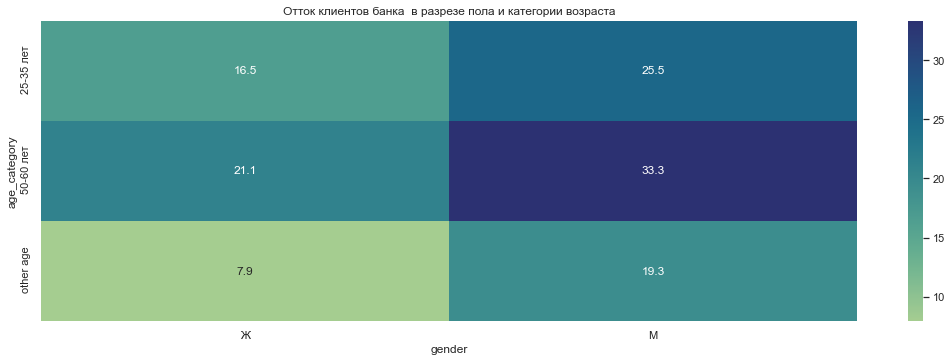

In [36]:
pivoted = pd.pivot_table(df_filtered, values='churn', index='age_category', columns='gender', aggfunc='mean')*100 
ax = sns.heatmap(data=pivoted, annot=True, fmt='.1f',cmap="crest")
plt.tight_layout()
plt.title('Отток клиентов банка  в разрезе пола и категории возраста')
plt.show()

По полученному выше графику мы видим, что доля оттока значительно выше нормы у клиентов мужского пола в возрасте 25-35 лет (25,5%) и 50-60 лет (33,3%). Далее сопоставим сгруппированные признаки по продуктам и объектам в собственности. 

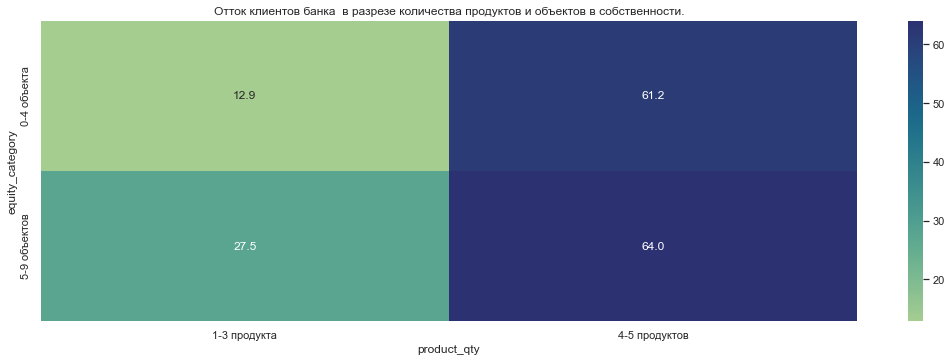

In [37]:
pivoted = pd.pivot_table(df_filtered, values='churn', index='equity_category', columns='product_qty', aggfunc='mean')*100 
ax = sns.heatmap(data=pivoted, annot=True, fmt='.1f',cmap="crest")
plt.tight_layout()
plt.title('Отток клиентов банка  в разрезе количества продуктов и объектов в собственности.')
plt.show()

На полученном графике мы видим, что примерно одинаковая доля оттока(61-64%) у всех пользователей 4-5 продуктов. Также можно отметить что среди пользователй 1-3 продуктов пользователи с объектами в собственности более 5 имеют отток выше нормы (27,5%). Проанализируем отток в разрезе возраста и количества продуктов.

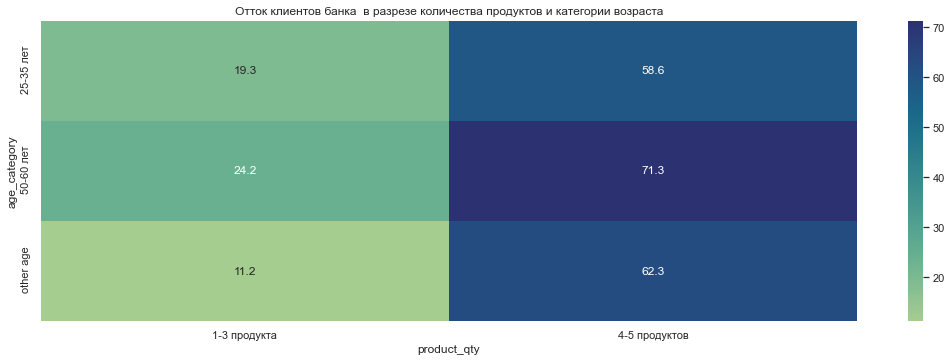

In [38]:
pivoted = pd.pivot_table(df_filtered, values='churn', index='age_category', columns='product_qty', aggfunc='mean')*100 
ax = sns.heatmap(data=pivoted, annot=True, fmt='.1f',cmap="crest")
plt.tight_layout()
plt.title('Отток клиентов банка  в разрезе количества продуктов и категории возраста')
plt.show() 

Здесь мы видим, что клиенты любого возраста склонны к оттоку, если у них 4-5 банковских продукта, а также в возрасте 50-60 лет если у них 1-3 продукта.

Попробуем объединить демографические признаки в один и построить  график еще раз.

In [39]:
df_filtered['age_by_gender'] = df_filtered['gender'] + df_filtered['age_category']
df_filtered.head(2)


C:\Users\marin\AppData\Local\Temp/ipykernel_14064/594993688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['age_by_gender'] = df_filtered['gender'] + df_filtered['age_category']


,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,...,city,gender,balance_is_anomaly,age_is_anomaly,is_any_anomaly,product_qty,age_category,equity_category,balance_category,age_by_gender
0,183012,850.000,25.000,1,59214.820,2,0,1,75719.140,1,...,Рыбинск,Ж,0,0,0,1-3 продукта,25-35 лет,0-4 объекта,"менее 0,75 млн.руб.",Ж 25-35 лет
1,146556,861.000,37.000,5,850594.330,3,1,0,86621.770,0,...,Рыбинск,Ж,0,0,0,1-3 продукта,other age,5-9 объектов,"более 0,75 млн.руб.",Ж other age


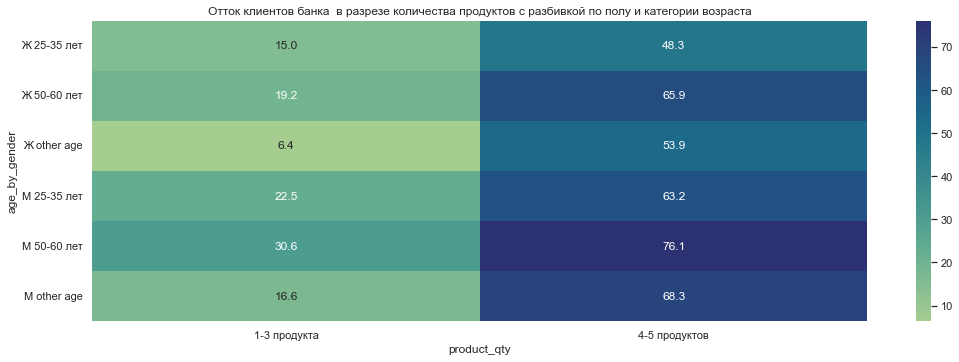

In [40]:
pivoted = pd.pivot_table(df_filtered, values='churn', index='age_by_gender', columns='product_qty', aggfunc='mean')*100 
ax = sns.heatmap(data=pivoted, annot=True, fmt='.1f',cmap="crest")
plt.tight_layout()
plt.title('Отток клиентов банка  в разрезе количества продуктов с разбивкой по полу и категории возраста')
plt.show() 

Здесь отчетливо видно, что самый высокий отток наблюдается у мужчин 50-60 лет в обеих категориях продукта. Среди клиентов, пользующихся  4-5 продуктами сильных различий нет, но в целом можно сказать что женщины люого возраста менее охотно уходят от банка.
Посмотрим на отток в разрезе демографических характеристик и объектов в собственности.

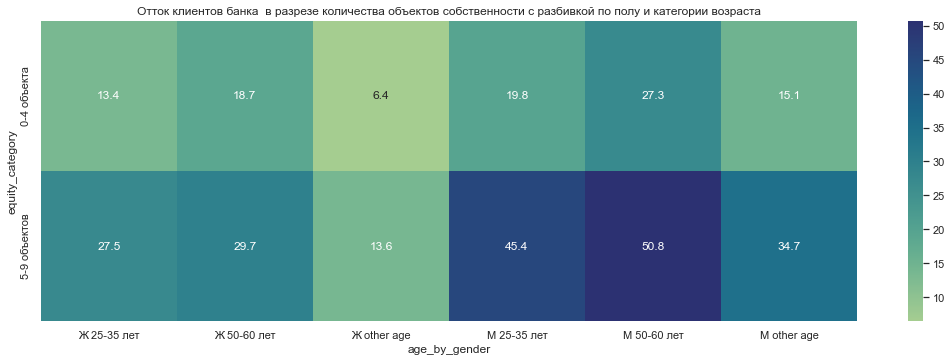

In [41]:
pivoted = pd.pivot_table(df_filtered, values='churn', index='equity_category', columns='age_by_gender', aggfunc='mean')*100 
ax = sns.heatmap(data=pivoted, annot=True, fmt='.1f',cmap="crest")
plt.tight_layout()
plt.title('Отток клиентов банка  в разрезе количества объектов собственности с разбивкой по полу и категории возраста')
plt.show()

Здесь мы видим, что чем больше объектов недвижимости у мужчин и женщин люого возраста, тем выше процент оттока. Посмотрим на отток в разрезе баланса и демографической характеристики.

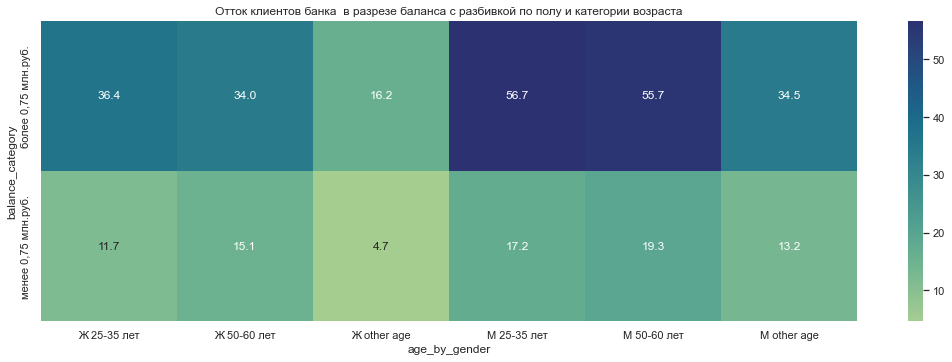

In [42]:
pivoted = pd.pivot_table(df_filtered, values='churn', index='balance_category', columns='age_by_gender', aggfunc='mean')*100 
ax = sns.heatmap(data=pivoted, annot=True, fmt='.1f',cmap="crest")
plt.tight_layout()
plt.title('Отток клиентов банка  в разрезе баланса с разбивкой по полу и категории возраста')
plt.show()

В полученной матрице отчетливо видно, что среди мужчин и женщин любого возраста нет исключений среди тех, у кого баланс на счете ниже 750 тыс. руб. Все кто имеет баланс выше этой суммы склонны уходить от банка.\
Создадим новую характеристику, которая объединит категории количества продуктов и объектов в собственности.

In [43]:
df_filtered['product_equity'] = df_filtered['product_qty'] + df_filtered['equity_category']
df_filtered.head(3)

C:\Users\marin\AppData\Local\Temp/ipykernel_14064/3867848122.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['product_equity'] = df_filtered['product_qty'] + df_filtered['equity_category']


,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,...,gender,balance_is_anomaly,age_is_anomaly,is_any_anomaly,product_qty,age_category,equity_category,balance_category,age_by_gender,product_equity
0,183012,850.000,25.000,1,59214.820,2,0,1,75719.140,1,...,Ж,0,0,0,1-3 продукта,25-35 лет,0-4 объекта,"менее 0,75 млн.руб.",Ж 25-35 лет,1-3 продукта 0-4 объекта
1,146556,861.000,37.000,5,850594.330,3,1,0,86621.770,0,...,Ж,0,0,0,1-3 продукта,other age,5-9 объектов,"более 0,75 млн.руб.",Ж other age,1-3 продукта 5-9 объектов
2,120722,892.000,30.000,0,NaN,1,1,1,107683.340,0,...,Ж,1,0,1,1-3 продукта,25-35 лет,0-4 объекта,"менее 0,75 млн.руб.",Ж 25-35 лет,1-3 продукта 0-4 объекта


Теперь посмотрим на отток клиентов разрезе наличия кредитной карты и с разбивкой по количеству продуктов и объектов собственности.

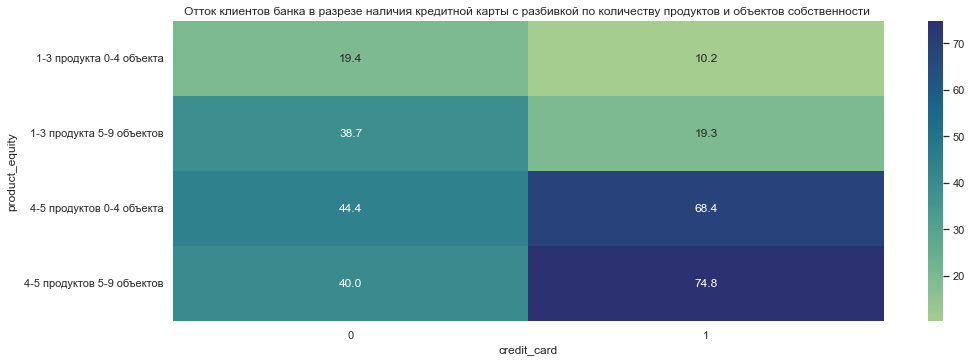

In [44]:
pivoted = pd.pivot_table(df_filtered, values='churn', index='product_equity', columns='credit_card', aggfunc='mean')*100 
ax = sns.heatmap(data=pivoted, annot=True, fmt='.1f',cmap="crest")
plt.tight_layout()
plt.title('Отток клиентов банка в разрезе наличия кредитной карты с разбивкой по количеству продуктов и объектов собственности ')
plt.show()

Судя по полученной матрице, клиенты с кредитной картой больше склонны к оттоку. Однако высокий отток в целом характерен с пользователей 4-5 продуктов или с количеством объектов в собственности более 5 как с кредитной картой так и без. Далее, посмотрим на матрицу активности клиентов. 

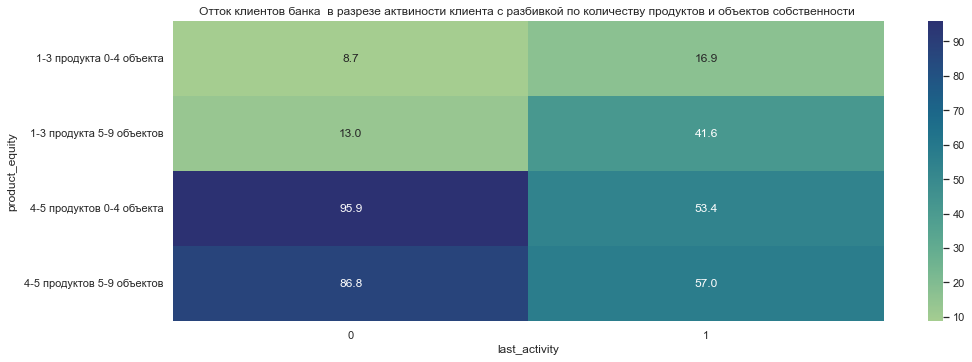

In [45]:
pivoted = pd.pivot_table(df_filtered, values='churn', index='product_equity', columns='last_activity', aggfunc='mean')*100 
ax = sns.heatmap(data=pivoted, annot=True, fmt='.1f',cmap="crest")
plt.tight_layout()
plt.title('Отток клиентов банка  в разрезе актвиности клиента с разбивкой по количеству продуктов и объектов собственности ')
plt.show()

Как мы видим, чаще уходят неактивные клиенты. Также тенденция для 4-5 продуктов неутешительна - отток от 53 до 96%. Однако среди пользователей 1-3 продукта с большим количеством недвижимости чаще ухоят активные клиенты.

Теперь построим финальную матрицу для определения финальных сегментов.

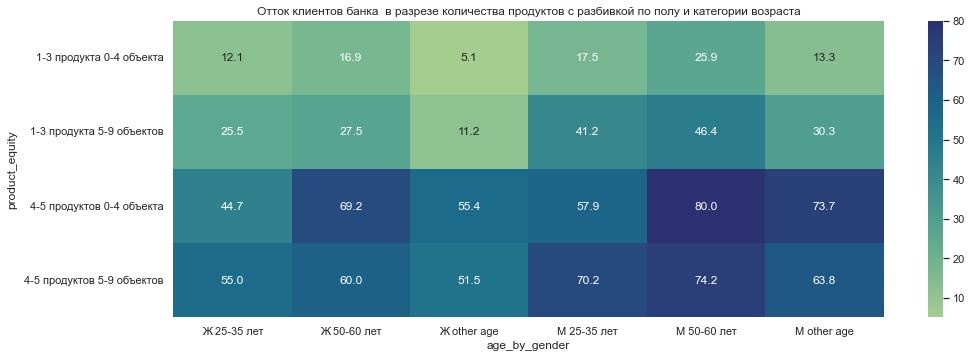

In [46]:
pivoted = pd.pivot_table(df_filtered, values='churn', index='product_equity', columns='age_by_gender', aggfunc='mean')*100 
ax = sns.heatmap(data=pivoted, annot=True, fmt='.1f',cmap="crest")
plt.tight_layout()
plt.title('Отток клиентов банка  в разрезе количества продуктов с разбивкой по полу и категории возраста')
plt.show()

Таким образом, благодаря полученной матрице мы можем явно выделить следующие сегменты, с оттоком выше нормы на 5%:

1. Женщины 25-35 и 50-60 лет, пользующиеся 1-3 продуктами и имеющими в собственности более 4 объектов. 
2. Мужчины любого возраста, пользующиеся 1-3 продуктами и имеющими в собственности более 4 объектов.
3. Женщины и мужчины любого возраста пользующиеся 4-5 продуктами.

Далее, посчитаем количество клиентов в каждом сегменте.

In [47]:
first_segment = df_filtered.query('age_by_gender != "Ж other age" and gender!= "М" and product_equity==" 1-3 продукта 5-9 объектов"')
print('Количество клиентов в первом сегменте', first_segment.shape[0])
first_segment_churn = round(first_segment['churn'].mean()*100)
print('Процент оттока в первом сегменте', first_segment_churn)

Количество клиентов в первом сегменте 471
Процент оттока в первом сегменте 26


In [48]:
second_segment = df_filtered.query('gender != "Ж" and product_equity==" 1-3 продукта 5-9 объектов"')
print('Количество клиентов во втором сегменте', second_segment.shape[0])
second_segment_churn = round(second_segment['churn'].mean()*100)
print('Процент оттока во втором сегменте', second_segment_churn)                      

Количество клиентов во втором сегменте 965
Процент оттока во втором сегменте 37


In [49]:
third_segment = df_filtered.query('product_qty == " 4-5 продуктов "')
print('Количество клиентов в третьем сегменте', third_segment.shape[0])
third_segment_churn = round(third_segment['churn'].mean()*100)
print('Процент оттока в третьем сегменте', third_segment_churn)

Количество клиентов в третьем сегменте 493
Процент оттока в третьем сегменте 62


Таким образом мы опредилили 3 сегмента с достаточным количеством клиентов в каждом и высоким процентом оттока. Для определения рекомендаций для каждого сегмента, посмотрим на распределение наличия кредитной карты среди сегментов.

In [50]:
credit_card_rate_fs = round(first_segment['credit_card'].mean()*100)
credit_card_rate_ss = round(second_segment['credit_card'].mean()*100)
credit_card_rate_ts = round(third_segment['credit_card'].mean()*100)
print('Процент наличия кредитной карты в первом сегменте', credit_card_rate_fs)
print('Процент наличия кредитной карты во втором сегменте', credit_card_rate_ss)   
print('Процент наличия кредитной карты в третьем сегменте', credit_card_rate_ts) 

Процент наличия кредитной карты в первом сегменте 55
Процент наличия кредитной карты во втором сегменте 59
Процент наличия кредитной карты в третьем сегменте 69


Мы видим, что у первого сегмента наименьший процент кредитных карт, что значит 45% процентам пользователей данного сегмента можно предложить приобрести кредитную карту для повышения их лояльности. 

### Выводы и рекомендации 

Мы получили данные банка МетанПром — данные о клиентах в трех городах: Ярославле, Рыбинске и Ростове Великом. С помощью предобработки данных мы смогли обработать полученный датасет, провести исследовательский анализ данных, проверить пару статистических гипотез. Это помогло нам выявить параметры, которые влияют на отток клиентов.

Мы исследовали портрет среднего пользователя банка: мужчина/женщина 40 лет, пользующиеся 2 продуктами банка, с 3 объектами собственности и средним счетом в 0,5 млн. руб. Мы выявили, что лояльным клиентом скорее является женщина в возрасте 35-50 или после 6о лет,имеющей до 2х банковских продуктов и до 5ти объектов собственности. 

Мы выявили, что на отток клиентов в большей степени оказывает влиянипе наличие большого остатка на счету (более 750 тыс. руб.), большое количество объектов в собственности (более 5) и 4-5 используемых банковских продукта. Мы выделили два возрастных диапазона клиентов, склонных к оттоку, это 25-35 ет и 50-60 лет. В дополнении к этому, в основном уходят активные пользователи без кредитной карты. Скорее всего это зарплатные клиенты, которые уходят при смене работы или при выходе на пенсию.

В дополнении, мы провели статистическую проверку различий между группами 1 и 2х продуктов и выявили, что разница в возрасте между двумя группами не имеет статистической значимости. Также, мы определили что гендерный признак имеет статистическую значимость между группами женскомго и мужчского пола.

Таким образом, благодаря выявленным параметрам и дополнительной статистической проверке, мы определили сегментацию клиентов, учитывая отток. Мы обнаружили одну общую черту характерную для всех выделенных сегментов: баланс на счете более 750 тыс. руб. Возможно это связано с тем, что банк предлагает выгодный процент на остаток до 750 тыс. руб. на балансе, а далее предложение становится невыгодными. На основании этого, сегменты, что мы выделили, следующие:


1. Женщины 25-35 и 50-60 лет, пользующиеся 1-3 продуктами и имеющими в собственности более 4 объектов (471 клиент, уровень оттока 26%). Для данного сегмента мы можем рекомендовать предложение по кредитной карте, т.к. мы выявили, что пользователи 1-3 продукта, пользующиеся кредитной картой, гораздо более лояльны к банку. Что значит, банк имеет хорошее предложение по кредитным картам. Если же у клиента уже есть кредитная карта, то можно предложить дополнительный процент на остаток более 750 тыс. руб. 

2. Мужчины любого возраста, пользующиеся 1-3 продуктами и имеющими в собственности более 4 объектов (966 клиентов, уровень оттока 37%).  Здесь стоит предложить выгодные условия по страхованию имущества и/или кэшбек на оплату коммунальных услуг.

3. Женщины и мужчины любого возраста пользующиеся 4-5 продуктами(493 клиента, уровень оттока 62%). Возможно сумма оплат за каждый банковский продукт выше чем у конкурентов, поэтому стоит сформировать предложение по скидке на количество продуктов, превышающих 4.


## Дашборд и презентация

Ссылка на Дашборд: https://public.tableau.com/views/test_2_16942518948570/Dashboard2?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link 

Ссылка на презентацию: https://disk.yandex.ru/d/p1uOr-iUURnrlA